# Step1. Extracting word features and show Exploratory Data Analysis (EDA) 
  ##   - Inspect the Data

In [32]:
import numpy as np
import itertools
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.feature_extraction.text import CountVectorizer

In [33]:
train_data = pd.read_csv("BBC News Train.csv")
test_data = pd.read_csv("BBC News Test.csv")
sample_data = pd.read_csv("BBC News Sample Solution.csv")

In [34]:
train_data.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


-> Train_data has only 3 columns.

In [35]:
print(train_data.info())
print(train_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
None
ArticleId    0
Text         0
Category     0
dtype: int64


-> Train_data has 1490 records and has no null record.

In [36]:
test_data.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [37]:
print(test_data.info())
print(test_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None
ArticleId    0
Text         0
dtype: int64


-> Train_data has 735 records and has no null record.

In [38]:
sample_data.head()

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,business
3,459,entertainment
4,1020,politics


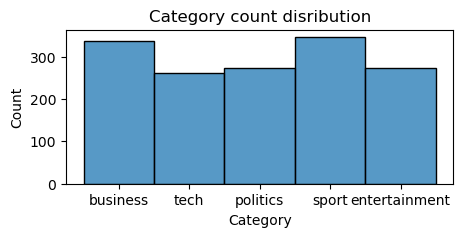

In [39]:
plt.figure(figsize=(5, 2))
sns.histplot(train_data, x = 'Category')
plt.title('Category count disribution')
plt.show()

-> There are five categories, with roughly the same number of samples in each category.

In [40]:
print('Category: {}\n'.format(train_data['Category'][0]))
print('Text:\n{}'.format(train_data['Text'][0]))

Category: business

Text:
worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices

-> Text column contains long text.

Word Count
the    34992
to     16568
of     12970
and    12366
a      12102
dtype: int64
--------------------------------------------------
Word Ratio
the    6.099685
to     2.888077
of     2.260886
and    2.155598
a      2.109579
dtype: float64
--------------------------------------------------


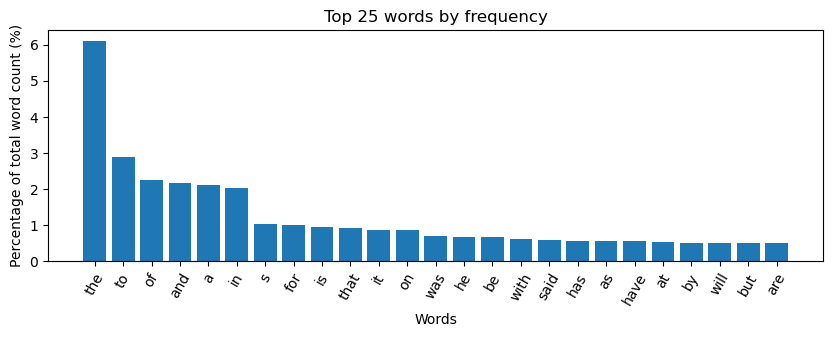

In [41]:
w = train_data['Text'].str.split(expand=True).unstack().value_counts()
print("Word Count")
print(w.head())
print("-"*50)
# Divides each element of a Text column into words separated by whitespace characters and returns a data frame with each word expanded as a new column.

l = w[:25]/np.sum(w)*100
print("Word Ratio")
print(l.head())
print("-"*50)

plt.figure(figsize=(10,3))
plt.bar(l.index, l.values)
plt.xlabel('Words')
plt.xticks(rotation=60)
plt.ylabel('Percentage of total word count (%)')
plt.title('Top 25 words by frequency')
plt.show()

-> Above graph is top 25 words by frequency. There are a lot of unnecessary words, such as prepositions, articles.

## - Data Cleaning 

It is necessary to omit words that have little information, are not relevant to the task.
These unneeded words are called stopwords.

In [42]:
# English dataset of stopwords
stop_words = set(stopwords.words('english'))

In [43]:
def get_clean_text(text):
    
    # Convert to lowercase
    text = text.lower()
    
    # Replace digits and single letters to space
    # - \b([a-zA-Z])\b : A letter of the alphabet between word boundaries
    # - \d+ : One or more numbers
    # - [.,!?()-\:%$£] : Punctuation, parentheses, and other symbols
    pattern = r'\b([a-zA-Z])\b|\d+|[.,!?()-\:%$£]'
    text = re.sub(pattern, '', text)
    words = word_tokenize(text)
    
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    
    # Join the words back into a string
    text = ' '.join(words)
    
    return text

In [44]:
# Numpy's vectorize function takes a python function and returns a vectorized version of that function.
npv = np.vectorize(get_clean_text)

# Clean train and test datasets
train_clean_data = npv(train_data['Text'])
test_clean_data = npv(test_data['Text'])

In [45]:
train_clean_data[0]

'worldcom exboss launches defence lawyers defending former worldcom chief bernie ebbers battery fraud charges called company whistleblower first witness cynthia cooper worldcom exhead internal accounting alerted directors irregular accounting practices us telecoms giant warnings led collapse firm following discovery bn bn accounting fraud mr ebbers pleaded guilty charges fraud conspiracy prosecution lawyers argued mr ebbers orchestrated series accounting tricks worldcom ordering employees hide expenses inflate revenues meet wall street earnings estimates ms cooper runs consulting business told jury new york wednesday external auditors arthur andersen approved worldcom accounting early said andersen given green light procedures practices used worldcom mr ebber lawyers said unaware fraud arguing auditors alert problems ms cooper also said shareholder meetings mr ebbers often passed technical questions company finance chief giving brief answers prosecution star witness former worldcom fin

Word Count
said     4838
mr       1973
would    1711
also     1426
new      1334
dtype: int64
--------------------------------------------------
Word Ratio
said     1.525086
mr       0.621950
would    0.539360
also     0.449519
new      0.420518
dtype: float64
--------------------------------------------------


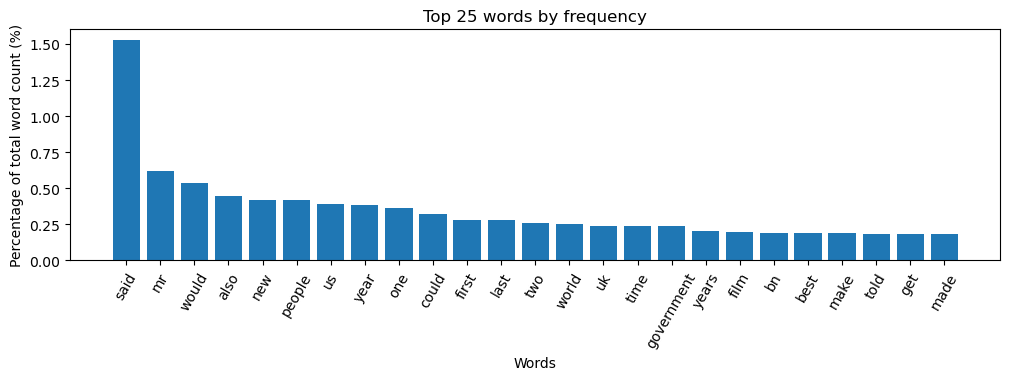

In [46]:
train_clean_data_seri = pd.Series(train_clean_data)
w = train_clean_data_seri.str.split(expand=True).unstack().value_counts()
print("Word Count")
print(w.head())
print("-"*50)
# Divides each element of a Text column into words separated by whitespace characters and returns a data frame with each word expanded as a new column.

l = w[:25]/np.sum(w)*100
print("Word Ratio")
print(l.head())
print("-"*50)

plt.figure(figsize=(12,3))
plt.bar(l.index, l.values)
plt.xlabel('Words')
plt.xticks(rotation=60)
plt.ylabel('Percentage of total word count (%)')
plt.title('Top 25 words by frequency')
plt.show()

-> Top 25 words after removing unnecessary characters. I can confirm that stop words can be excluded.

# Step2. Building and training models.

I tried two models. First one is NMF + Bag-of-Words. This is not high accuracy, so I tried NMF + TF-IDF to increase the accuracy. As a result, I was able to confirm the improvement of the model accuracy.

## - Bag-of-Words

Bag-of-Words can be summarized simply as:
- A model that puts words in a sentence into a bag.
- Classification and evaluation based on the number of times a word appears.
- The order of words is not taken into account.

In [47]:
# Convert text to word vecter(Bag-of-Words)
vectorizer = CountVectorizer(max_features=10000)
word_vec = vectorizer.fit(train_clean_data)
X_train_vec = word_vec.transform(train_clean_data)
X_test_vec = word_vec.transform(test_clean_data)

y_train_vec = train_data['Category']
y_test_vec = sample_data['Category']

feature_names = vectorizer.get_feature_names_out()
pd.DataFrame(X_train_vec.toarray(), columns=feature_names)

,aaa,aaliyah,abandoned,abandoning,abba,abbas,abbasi,abbott,abc,aberdeen,...,zeppelin,zero,zhang,zimbabwe,ziyi,zombies,zone,zones,zurich,zvonareva
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1486,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1487,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1488,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


NMF requires the use of some kind of matrix and cannot handle text data as is. Now that the matrix has been obtained, NMF is used to make predictions.

In [48]:
def get_max_accuracy(y_true, y_pred):
   
    #print(y_pred)
    y_pred = np.argmax(y_pred, axis = 1)
    #print(y_pred)
    l = np.unique(y_true)
    t = y_true.values
    mx = 0
    
    # Sort the results predicted by NMF and take the maximum value
    for p in itertools.permutations(range(len(l))):
        c = np.array([l[p.index(x)] for x in y_pred])
        v = np.mean(c == t)
        if v > mx:
            P = p
        mx = max(mx,v)      
    
    return mx

In [49]:
class NMF_custom(BaseEstimator, ClassifierMixin):
   
    def __init__(self, n_components = 5, init = None, l1_ratio = 0, max_iter = 200):
    # Components is set to 5 because the number of categories to predict is 5

        self.n_components = n_components
        self.init = init
        self.l1_ratio = l1_ratio
        self.max_iter = max_iter

        
    def fit(self, X, y=None):
        
        self.nmf = NMF(n_components = self.n_components
                       , init = self.init
                       , l1_ratio = self.l1_ratio
                       , max_iter = self.max_iter)
        self.nmf.fit(X)
        return self

    
    def predict(self, X):
        
        return self.nmf.transform(X)

In [50]:
# NMF + Bag-of-Words

warnings.simplefilter('ignore')

# Number of unique categories
n_unq_cat = len(np.unique(train_data['Category'].values))

params = {'n_components': [n_unq_cat],
          'init': ['random', 'nndsvda'],
          'l1_ratio': [0.0, 0.5, 1.0],
          'max_iter': [200, 400, 600]}

grid = GridSearchCV(estimator = NMF_custom(),
                    param_grid = params,
                    scoring = make_scorer(get_max_accuracy),
                    cv = 5)

grid = grid.fit(X_train_vec, y_train_vec) 
grid.cv_results_ = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')
run = grid.cv_results_['mean_fit_time'] + grid.cv_results_['mean_score_time'] 
test = grid.cv_results_['mean_test_score']

print("＜Result Table＞ - Results in order of score")
for ru, te, params in zip(run, test, grid.cv_results_['params']):
    print("mean test score = %0.3f,  mean runtime = %0.3f  for %r"% (te, ru, params))

＜Result Table＞ - Results in order of score
mean test score = 0.599,  mean runtime = 1.049  for {'init': 'random', 'l1_ratio': 0.0, 'max_iter': 200, 'n_components': 5}
mean test score = 0.592,  mean runtime = 0.970  for {'init': 'nndsvda', 'l1_ratio': 1.0, 'max_iter': 200, 'n_components': 5}
mean test score = 0.592,  mean runtime = 0.969  for {'init': 'nndsvda', 'l1_ratio': 0.5, 'max_iter': 600, 'n_components': 5}
mean test score = 0.592,  mean runtime = 0.967  for {'init': 'nndsvda', 'l1_ratio': 0.5, 'max_iter': 400, 'n_components': 5}
mean test score = 0.592,  mean runtime = 0.982  for {'init': 'nndsvda', 'l1_ratio': 0.5, 'max_iter': 200, 'n_components': 5}
mean test score = 0.592,  mean runtime = 0.978  for {'init': 'nndsvda', 'l1_ratio': 0.0, 'max_iter': 600, 'n_components': 5}
mean test score = 0.592,  mean runtime = 0.998  for {'init': 'nndsvda', 'l1_ratio': 0.0, 'max_iter': 400, 'n_components': 5}
mean test score = 0.592,  mean runtime = 0.985  for {'init': 'nndsvda', 'l1_ratio':

-> Due to the poor accuracy, another method was tried in the next.

## - TF-IDF

TF-IDF is the product of TF (Term Frequency) and IDF (Inverse Document Frequency):
- TF represents the percentage of occurrences of a word in a document.
- IDF is the degree which the certain word appears in only a portion of the document, not the entire document.

-> So TF-IDF means:
- The target word appears in large numbers in a single document.
- However, the word does not appear frequently throughout the document, but only in some specific documents

In [51]:
# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(sublinear_tf = True
                             , min_df = 5
                             , stop_words = 'english'
                             , norm = 'l2'
                             , encoding = 'latin-1'
                             , ngram_range = (1,2)
                             )
tfidf_vect = vectorizer.fit(train_clean_data)
X_train = tfidf_vect.transform(train_clean_data)
X_test = tfidf_vect.transform(test_clean_data)

y_train = train_data['Category']
y_test = sample_data['Category']

feature_names = vectorizer.get_feature_names_out()
pd.DataFrame(X_train.toarray(), columns=feature_names)

,abandoned,abbott,abc,abilities,ability,able,able access,able make,able play,able watch,...,zach,zach braff,zealand,zeppelin,zero,zero tolerance,zhang,zone,zurich,zurich premiership
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.034612,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1486,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1487,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1488,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


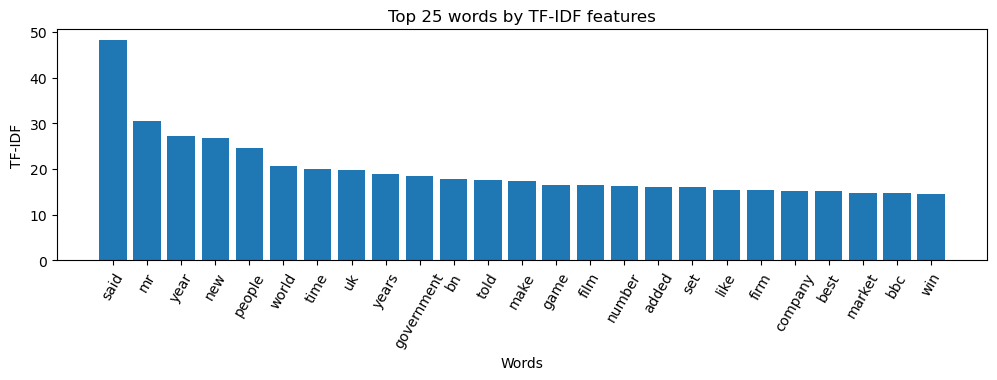

In [52]:
# TOP25 words
df_vectorized = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names_out())
#print(df_vectorized)

top_25_keywords = df_vectorized.sum().nlargest(25)

plt.figure(figsize=(12,3))
plt.bar(top_25_keywords.index, top_25_keywords.values)
plt.xlabel('Words')
plt.xticks(rotation=60)
plt.ylabel('TF-IDF')
plt.title('Top 25 words by TF-IDF features')
plt.show()

Now that the TF-IDF matrix has been obtained, NMF is used to make predictions. I tried various parameters in the grid search.

In [53]:
# NMF + TF-IDF

warnings.simplefilter('ignore')

# Number of unique categories
n_unq_cat = len(np.unique(train_data['Category'].values))

params = {'n_components': [n_unq_cat],
          'init': ['random', 'nndsvda'],
          'l1_ratio': [0.0, 0.5, 1.0],
          'max_iter': [200, 400, 600]}

grid = GridSearchCV(estimator = NMF_custom(),
                    param_grid = params,
                    scoring = make_scorer(get_max_accuracy),
                    cv = 5)

grid = grid.fit(X_train, y_train) 
grid.cv_results_ = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')
run = grid.cv_results_['mean_fit_time'] + grid.cv_results_['mean_score_time'] 
test = grid.cv_results_['mean_test_score']

print("＜Result Table＞ - Results in order of score")
for ru, te, params in zip(run, test, grid.cv_results_['params']):
    print("mean test score = %0.3f,  mean runtime = %0.3f  for %r"% (te, ru, params))

＜Result Table＞ - Results in order of score
mean test score = 0.952,  mean runtime = 0.480  for {'init': 'random', 'l1_ratio': 1.0, 'max_iter': 400, 'n_components': 5}
mean test score = 0.952,  mean runtime = 0.517  for {'init': 'random', 'l1_ratio': 1.0, 'max_iter': 200, 'n_components': 5}
mean test score = 0.949,  mean runtime = 0.582  for {'init': 'random', 'l1_ratio': 0.0, 'max_iter': 400, 'n_components': 5}
mean test score = 0.948,  mean runtime = 0.427  for {'init': 'random', 'l1_ratio': 1.0, 'max_iter': 600, 'n_components': 5}
mean test score = 0.947,  mean runtime = 0.591  for {'init': 'nndsvda', 'l1_ratio': 1.0, 'max_iter': 200, 'n_components': 5}
mean test score = 0.947,  mean runtime = 0.586  for {'init': 'nndsvda', 'l1_ratio': 0.5, 'max_iter': 600, 'n_components': 5}
mean test score = 0.947,  mean runtime = 0.567  for {'init': 'nndsvda', 'l1_ratio': 0.5, 'max_iter': 400, 'n_components': 5}
mean test score = 0.947,  mean runtime = 0.570  for {'init': 'nndsvda', 'l1_ratio': 0.

In [54]:
# This is an accuracy function for submission
def get_max_accuracy2(y_true, y_pred):
   
    #print(y_pred)
    y_pred = np.argmax(y_pred, axis = 1)
    #print(y_pred)
    l = np.unique(y_true)
    t = y_true.values
    mx = 0
    P = []
    L = []
    
    # Sort the results predicted by NMF and take the maximum value
    for p in itertools.permutations(range(len(l))):
        c = np.array([l[p.index(x)] for x in y_pred])
        v = np.mean(c == t)
        if v > mx:
            P = p
        mx = max(mx,v)       
    for i in range(len(l)):
        L.append((l[i],P[i]))
    return mx, L

In [58]:
# NMF + TF-IDF for submission

warnings.simplefilter('ignore')

# Number of unique categories
n_unq_cat = len(np.unique(train_data['Category'].values))

nmf = NMF(n_components = n_unq_cat,
            init = 'random',
            l1_ratio = 1.0,
            max_iter = 200 )

nmf = nmf.fit(X_train)
mx, L = get_max_accuracy2(y_train, nmf.transform(X_train))
print(mx)
print(L)

0.9516778523489933
[('business', 1), ('entertainment', 4), ('politics', 3), ('sport', 2), ('tech', 0)]


In [59]:
#submission
test_data['Category'] = np.argmax(nmf.transform(X_test), axis = 1)
for i in range(n_unq_cat):
    test_data['Category'][test_data['Category'] == L[i][1]] = L[i][0]

submit = test_data
submit = submit.drop('Text', axis=1)
print(submit.head(10))

submit.to_csv('submission.csv', index=False)

   ArticleId       Category
0       1018          sport
1       1319           tech
2       1138          sport
3        459       business
4       1020          sport
5         51          sport
6       2025       politics
7       1479       politics
8         27  entertainment
9        397       business


-> I submitted the result to Kaggle and got score"0.96".
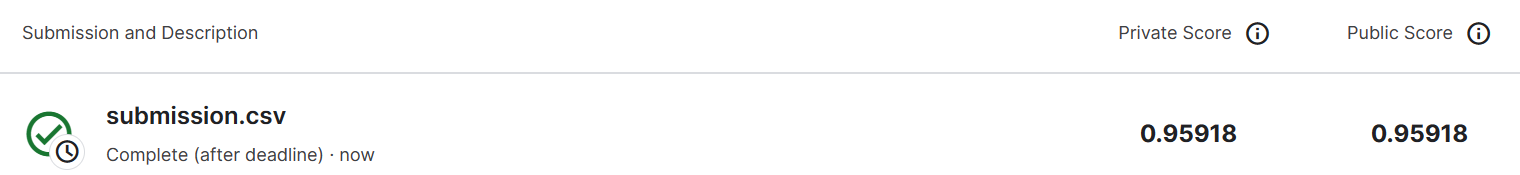

# Step3. Compare with supervised learning

The following three models were built as supervised learning and compared with NMF.
- Random Forest
- SVM
- Logistic Regression<br>

At the same time, the number of samples was changed to 10%, 20%, 50% and 100% to check the behavior of each model.

In [29]:
# 10%, 20%, 50% 100% data

ratio = [0.1, 0.2, 0.5, 1.0]

for r in ratio:
    
    print("Data Ratio :", r)
    print("NMF + TF-IDF")
    warnings.simplefilter('ignore')
    n_unq_cat = len(np.unique(train_data['Category'].values))
    params = {'n_components': [n_unq_cat], 'init': ['random', 'nndsvda'], 'l1_ratio': [0.0, 0.5, 1.0], 'max_iter': [200, 400, 600]}
    grid = GridSearchCV(estimator = NMF_custom(), param_grid = params, scoring = make_scorer(get_max_accuracy), cv = 5)
    grid = grid.fit(X_train[:int(X_train.shape[0] * r)], y_train[:int(y_train.shape[0] * r)]) 
    grid.cv_results_ = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')
    run = grid.cv_results_['mean_fit_time'] + grid.cv_results_['mean_score_time'] 
    test = grid.cv_results_['mean_test_score']
    for ru, te, params in zip(run, test, grid.cv_results_['params']):
        print("mean test score = %0.3f,  mean runtime = %0.3f  for %r"% (te, ru, params))
    
    print("Random Forest")
    params = {'max_depth':[2 ** i for i in range(7, 9)], 'n_estimators':[2 ** i for i in range(7, 9)],}
    clf = RandomForestClassifier()
    grid = GridSearchCV( clf, params, cv = 5 )
    grid = grid.fit(X_train[:int(X_train.shape[0] * r)], y_train[:int(y_train.shape[0] * r)]) 
    grid.cv_results_ = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')
    run = grid.cv_results_['mean_fit_time'] + grid.cv_results_['mean_score_time'] 
    test = grid.cv_results_['mean_test_score']
    for ru, te, params in zip(run, test, grid.cv_results_['params']):
        print("mean test score = %0.3f,  mean runtime = %0.3f  for %r"% (te, ru, params))
    
    print("SVM")
    c_range = np.logspace(-3, 2, 2, base=2)
    g_range = np.logspace(-3, 2, 2, base=2)
    params = dict(gamma=g_range, C=c_range)
    clf2 = SVC( kernel="rbf")
    grid = GridSearchCV( clf2, params, cv = 5 )
    grid = grid.fit(X_train[:int(X_train.shape[0] * r)], y_train[:int(y_train.shape[0] * r)]) 
    grid.cv_results_ = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')
    run = grid.cv_results_['mean_fit_time'] + grid.cv_results_['mean_score_time'] 
    test = grid.cv_results_['mean_test_score']
    for ru, te, params in zip(run, test, grid.cv_results_['params']):
        print("mean test score = %0.3f,  mean runtime = %0.3f  for %r"% (te, ru, params))
    
    print("Logistic Regression")
    params = {'C':[2 ** i for i in range(-5, 6)]}
    clf3 = LogisticRegression(solver='liblinear')
    grid = GridSearchCV( clf3, params, cv = 5 )
    grid = grid.fit(X_train[:int(X_train.shape[0] * r)], y_train[:int(y_train.shape[0] * r)]) 
    grid.cv_results_ = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')
    run = grid.cv_results_['mean_fit_time'] + grid.cv_results_['mean_score_time'] 
    test = grid.cv_results_['mean_test_score']
    for ru, te, params in zip(run, test, grid.cv_results_['params']):
        print("mean test score = %0.3f,  mean runtime = %0.3f  for %r"% (te, ru, params))
    
    print("="*50)

Data Ratio : 0.1
NMF + TF-IDF
mean test score = 0.677,  mean runtime = 0.785  for {'init': 'nndsvda', 'l1_ratio': 1.0, 'max_iter': 600, 'n_components': 5}
mean test score = 0.677,  mean runtime = 0.774  for {'init': 'nndsvda', 'l1_ratio': 0.5, 'max_iter': 600, 'n_components': 5}
mean test score = 0.677,  mean runtime = 0.817  for {'init': 'nndsvda', 'l1_ratio': 1.0, 'max_iter': 400, 'n_components': 5}
mean test score = 0.677,  mean runtime = 0.774  for {'init': 'nndsvda', 'l1_ratio': 0.0, 'max_iter': 400, 'n_components': 5}
mean test score = 0.677,  mean runtime = 0.789  for {'init': 'nndsvda', 'l1_ratio': 0.0, 'max_iter': 600, 'n_components': 5}
mean test score = 0.677,  mean runtime = 0.767  for {'init': 'nndsvda', 'l1_ratio': 0.5, 'max_iter': 400, 'n_components': 5}
mean test score = 0.670,  mean runtime = 0.663  for {'init': 'nndsvda', 'l1_ratio': 1.0, 'max_iter': 200, 'n_components': 5}
mean test score = 0.657,  mean runtime = 0.460  for {'init': 'random', 'l1_ratio': 1.0, 'max_it

mean test score = 0.936,  mean runtime = 8.163  for {'max_depth': 128, 'n_estimators': 256}
mean test score = 0.930,  mean runtime = 8.229  for {'max_depth': 256, 'n_estimators': 256}
mean test score = 0.928,  mean runtime = 4.089  for {'max_depth': 128, 'n_estimators': 128}
mean test score = 0.925,  mean runtime = 4.118  for {'max_depth': 256, 'n_estimators': 128}
SVM
mean test score = 0.961,  mean runtime = 2.397  for {'C': 4.0, 'gamma': 0.125}
mean test score = 0.483,  mean runtime = 2.546  for {'C': 4.0, 'gamma': 4.0}
mean test score = 0.240,  mean runtime = 2.455  for {'C': 0.125, 'gamma': 0.125}
mean test score = 0.240,  mean runtime = 2.569  for {'C': 0.125, 'gamma': 4.0}
Logistic Regression
mean test score = 0.960,  mean runtime = 0.113  for {'C': 4}
mean test score = 0.956,  mean runtime = 0.132  for {'C': 32}
mean test score = 0.956,  mean runtime = 0.126  for {'C': 8}
mean test score = 0.956,  mean runtime = 0.121  for {'C': 16}
mean test score = 0.952,  mean runtime = 0.110

### Summary
<br>
10% data:<br>
- NMF + TF-IDF : mean test score = 0.677,  mean runtime = 0.785 <br>
- Random Forest : mean test score = 0.799,  mean runtime = 3.010 <br>
- SVM : mean test score = 0.820,  mean runtime = 0.110<br>
- Logistic Regression : mean test score = 0.886,  mean runtime = 0.035<br>
<br>
20% data:<br>
- NMF + TF-IDF : mean test score = 0.896,  mean runtime = 0.358 <br>
- Random Forest : mean test score = 0.913,  mean runtime = 2.208 <br>
- SVM : mean test score = 0.960,  mean runtime = 0.418<br>
- Logistic Regression : mean test score = 0.956,  mean runtime = 0.053<br> 
<br>
50% data:<br>
- NMF + TF-IDF : mean test score = 0.948,  mean runtime = 0.596 <br>
- Random Forest : mean test score = 0.936,  mean runtime = 8.163 <br>
- SVM : mean test score = 0.961,  mean runtime = 2.397<br>
- Logistic Regression : mean test score = 0.960,  mean runtime = 0.113<br> 
<br>
full data:<br>
- NMF + TF-IDF : mean test score = 0.950,  mean runtime = 0.521 <br>
- Random Forest : mean test score = 0.961,  mean runtime = 14.078 <br>
- SVM : mean test score = 0.977,  mean runtime = 8.865<br>
- Logistic Regression : mean test score = 0.977,  mean runtime = 0.229

About runtime
-  Logistic Regression is the fastest in all sample sizes.
-  NMF + TF-IDF is relatively fast, and run times are about the same through all sample numbers.Other models have increased in run time as the number of samples increased.

About accuracy
- Accuracy improved with increasing sample size for all models.
- SVM and Logistic Regression had higher accuracy results.